In [5]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner
from datetime import datetime

# Setting up fake observations

In [6]:
true_state = state.State(planets=[{"m":0.94e-3, "a":0.226, "h":-0.045, "k":-0.015, "l":1.265}, {"m":1.965e-3, "a":0.307, "h":-0.035, "k":-0.00, "l":1.76}])
obs = observations.FakeObservation(true_state, Npoints=200, error=1.8e-4, errorVar=3.5e-5, tmax=(60))
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(obs), color="blue")
plt.errorbar(obs.t, obs.rv, yerr=obs.err, fmt='.r')
ax.set_xticklabels([])
plt.grid()
frame2=fig.add_axes([0.125, -0.17, 0.775, 0.22])        
plt.errorbar(obs.t, true_state.get_rv(obs.t)-obs.rv, yerr=obs.err, fmt='.r')
plt.grid()

TypeError: __init__() got an unexpected keyword argument 'h'

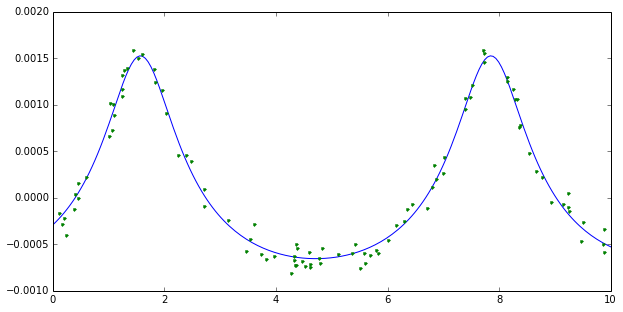

# MCMC

In [9]:
Nwalkers = 10
ens = mcmc.Ensemble(true_state,obs,scales={"m":1e-3, "a":1., "h":0.8, "k":0.8, "l":np.pi},nwalkers=Nwalkers)
Niter = 10000
chain = np.zeros((Niter,ens.state.Nvars))
chainlogp = np.zeros(Niter)
f = FloatProgress(min=0, max=Niter/Nwalkers)
display(f)
for i in range(Niter/Nwalkers):
    ens.step_force()
    for j in range(Nwalkers):
        chain[j*Niter/Nwalkers+i] = ens.states[j]
        chainlogp[j*Niter/Nwalkers+i] = ens.lnprob[j]
    f.value = i

emcee: Exception while calling your likelihood function:
  params: [  1.00183278e+00   1.97291592e-01   7.52893837e-03   9.93330250e-04
   2.94362534e-05]
  args: [<mcmc.Ensemble object at 0xaf4fe0ac>]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "mcmc.py", line 22, in lnprob
    logp = e.state.get_logp(e.obs)
  File "state.py", line 50, in get_logp
    self.logp = -self.get_chi2(obs)
  File "state.py", line 42, in get_chi2
    rv = self.get_rv(obs.t)
  File "state.py", line 32, in get_rv
    sim.integrate(t)
  File "rebound/simulation.py", line 992, in integrate
    ret_value = clibrebound.reb_integrate(byref(self), c_double(tmax))
KeyboardInterrupt


KeyboardInterrupt: 

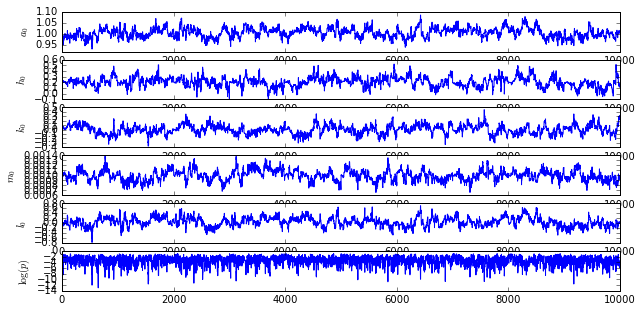

In [9]:
fig = plt.figure(figsize=(10,5))
for i in range(ens.state.Nvars):
    ax = plt.subplot(ens.state.Nvars+1,1,1+i)
    ax.set_ylabel(ens.state.get_keys()[i])
    ax.plot(chain[:,i])
ax = plt.subplot(ens.state.Nvars+1,1,ens
                 .state.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

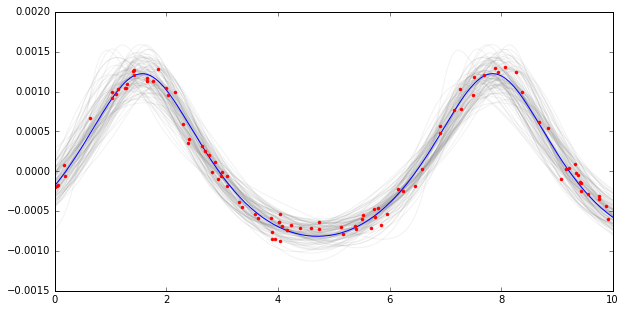

In [10]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = ens.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

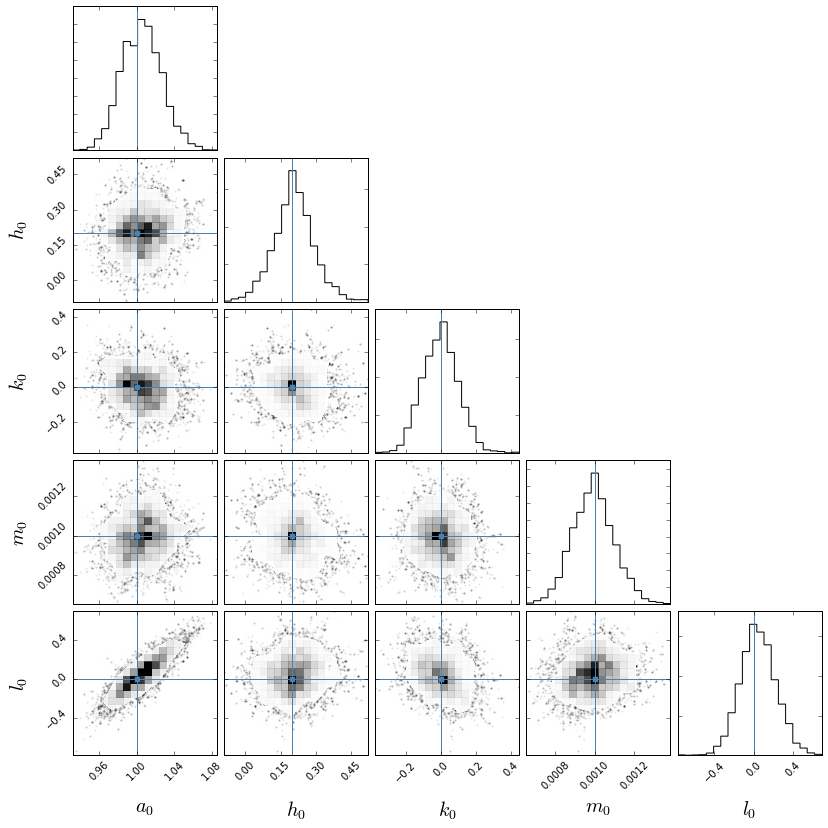

In [11]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})